Global life expectancy versus income
==================
In the hunt for larger datasets to play with, I started looking at global data provided by the UN from http://data.un.org.
The typical example you see if life expectancy versus income, so let's see how easy it is to compare that.

Gross National Income (GNI)
-----------------------------
This indicator is defined:

http://data.worldbank.org/indicator/NY.GNP.PCAP.PP.CD

We can download the UN 'GNI per capita, PPP (current international $)' dataset from:

http://data.un.org/Data.aspx?d=WDI&f=Indicator_Code:NY.GNP.PCAP.PP.CD&c=2,4,5&s=Country_Name:asc,Year:desc&v=1

The raw data looks like:

In [1]:
import pandas
pandas.read_csv('../data/un/wdi-gni-per-capita-ppp.csv').head()

,Country or Area,Year,Value,Value Footnotes
0,Afghanistan,2013,1960,NaN
1,Afghanistan,2012,1940,NaN
2,Afghanistan,2011,1700,NaN
3,Afghanistan,2010,1610,NaN
4,Afghanistan,2009,1500,NaN


That's good - but we don't need all the historical data - let's just extract the data from 2012:

In [2]:
df_gni = pandas.read_csv('../data/un/wdi-gni-per-capita-ppp.csv')
# find only the rows from 2012
df_gni_2012 = df_gni[df_gni['Year'] == '2012'].copy()
# drop the 'Value Footnotes' and 'Year' columns
df_gni_2012.drop('Value Footnotes', axis=1, inplace=True)
df_gni_2012.drop('Year', axis=1, inplace=True)
# rename the remaining columns and set the index
df_gni_2012.columns = ['Country', 'GNI']
df_gni_2012.set_index('Country', inplace=True)
df_gni_2012.head()

,GNI
Country,
Afghanistan,1940
Albania,9930
Algeria,12860
Angola,6580
Antigua and Barbuda,20060


Life expectancy
----------------
Now we load the UN life ecpectancy data, retrieved from:

http://data.un.org/Data.aspx?d=WHO&f=MEASURE_CODE:WHOSIS_000001&c=2,4,6,10&s=_crEngNameOrderBy:asc,_timeEngNameOrderBy:desc&v=1

In [3]:
pandas.read_csv('../data/un/who-life-expectancy-at-birth.csv').head()

,Country or Area,Year(s),GENDER,Value,Value Footnotes
0,Afghanistan,2012,Male,58,NaN
1,Afghanistan,2012,Female,61,NaN
2,Afghanistan,2012,Both sexes,60,NaN
3,Afghanistan,2000,Male,54,NaN
4,Afghanistan,2000,Female,56,NaN


Again, we're only interested in the current data, so let's extract what we need:

In [4]:
df_life = pandas.read_csv('../data/un/who-life-expectancy-at-birth.csv')
# find only the rows from 2012
df_life.rename(columns={'Year(s)':'Year'}, inplace=True)
df_life_2012 = df_life[df_life['Year'] == 2012].copy()
# drop the 'Value Footnotes' and 'Year' columns
df_life_2012.drop('Value Footnotes', axis=1, inplace=True)
df_life_2012.drop('Year', axis=1, inplace=True)
# rename the remaining columns
df_life_2012.columns = ['Country', 'Gender', 'Expectancy']
# set the index to a composite key
df_life_2012.set_index('Country', inplace=True)
df_life_2012.head()

,Gender,Expectancy
Country,,
Afghanistan,Male,58
Afghanistan,Female,61
Afghanistan,Both sexes,60
Albania,Male,73
Albania,Female,75


Combining GNI and life expectancy datasets
--------------------------------------------
We can 'join' the datasets on the 'Country' column, as we would with database tables.

In [5]:
# Note: we use an inner join as we're only interested in countries that we have both data for
df_combined = df_gni_2012.join(df_life_2012, how='inner')
df_combined = df_combined[df_combined['Gender'] != 'Both sexes']
df_combined.head()

,GNI,Gender,Expectancy
Country,,,
Afghanistan,1940,Male,58
Afghanistan,1940,Female,61
Albania,9930,Male,73
Albania,9930,Female,75
Algeria,12860,Male,70


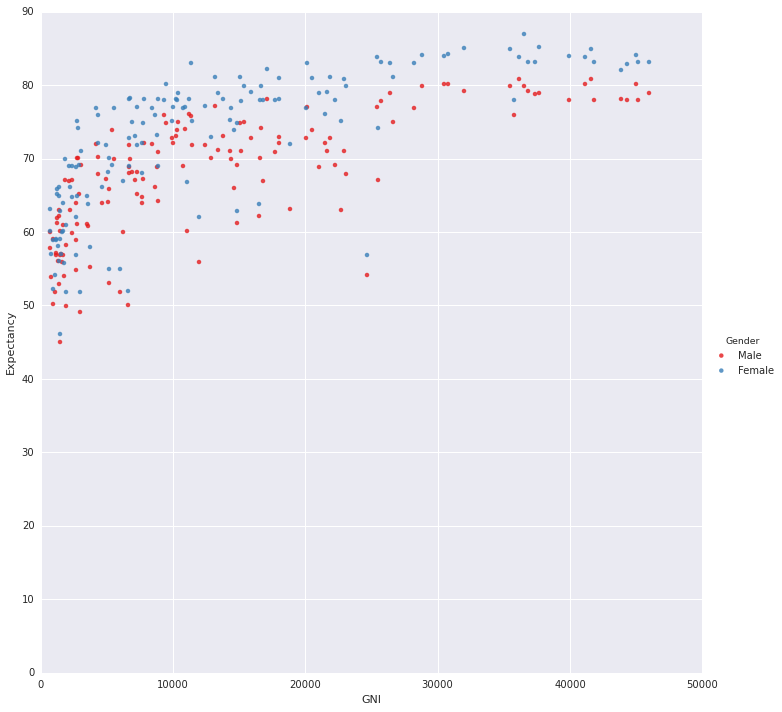

In [6]:
import seaborn
%matplotlib inline
grid = seaborn.lmplot('GNI', 'Expectancy', data=df_combined, hue='Gender', fit_reg=False, size=10, y_jitter=0.2, palette='Set1')
grid.set(xlim=(0, 50000), ylim=(0, 90))

Two interesting things jump out when you plot the data:
- women universally living longer than men; this is well-known, but maybe it's interesting to see how this gap is affected by income - is the gap constant, or is there some sort of linear or otherwise relationship to income?
- there's a very clear outlier with good income around 25k, but sub-60 year life expectancy - where could this be?

Let's try to identify the outlier first:

In [7]:
df_combined[(df_combined['GNI'] > 20000) & (df_combined['Expectancy'] < 60)]

,GNI,Gender,Expectancy
Country,,,
Equatorial Guinea,24660,Male,54
Equatorial Guinea,24660,Female,57


A bit of googling quickly identifies the reasons for this outlier:

>    "The discovery of large oil reserves in 1996 and its subsequent exploitation have contributed to a dramatic increase in government revenue."
    https://en.wikipedia.org/wiki/Economy_of_Equatorial_Guinea

And the effect this has had on the economy is clearly seen when comparing to Spain: https://en.wikipedia.org/wiki/File:Rent_Equatorial_Guinea.png

So the economy is surging, but life expectancy has yet to catch up - it would be interesting to monitor the progress of life expectancy in this country to see how far it lags.


Let's take a look now at the life expectancy discrepancy between male and female.
The simple thing to do is just plot the difference:

In [8]:
# first, pivot the dataframe so that Male and Female become columns
df_pivot = df_combined.pivot(index=df_combined.index, columns='Gender')
df_pivot.head()

GNI        Expectancy     
Gender              Female   Male     Female Male
Country                                          
Afghanistan           1940   1940         61   58
Albania               9930   9930         75   73
Algeria              12860  12860         73   70
Angola                6580   6580         52   50
Antigua and Barbuda  20060  20060         77   73

Note that the GNI values in the pivoted table are now duplicated - they're the same for men and women.

Let's get the data we need for the plot into a new dataframe:

In [9]:
df_gap = pandas.DataFrame()
df_gap['GNI'] = df_pivot['GNI', 'Female']
df_gap['Gap'] = df_pivot['Expectancy', 'Female'] - df_pivot['Expectancy', 'Male']
df_gap.head()

,GNI,Gap
Country,,
Afghanistan,1940,3
Albania,9930,2
Algeria,12860,3
Angola,6580,2
Antigua and Barbuda,20060,4


[(0, 80000)]

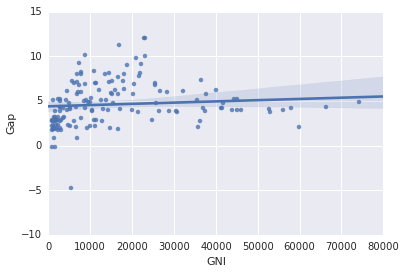

In [10]:
seaborn.regplot('GNI', 'Gap', data=df_gap, y_jitter=0.3).set(xlim=(0,80000))

So we can see that there is a lot more variation between countries with lower GNI.
And in very poor countries there is little difference between men and women, perhaps because they don't get the opportunity to reach a 'natural' old age, due to disease, malnutrition, etc.

Again, plotting the data provides an obvious outlier - a country where men reliably outlive women:

In [11]:
df_gap[df_gap['Gap'] < 0]

,GNI,Gap
Country,,
Tonga,5370,-5


Regression using k-nearest neighbours
---------------------------------------

In [12]:
# get the columns we need to do knn regression
df_knn = pandas.DataFrame()
df_knn['Male Expectancy'] = df_pivot['Expectancy', 'Male']
df_knn['Female Expectancy'] = df_pivot['Expectancy', 'Female']
df_knn['GNI'] = df_pivot['GNI', 'Male']
df_knn.head()

,Male Expectancy,Female Expectancy,GNI
Country,,,
Afghanistan,58,61,1940
Albania,73,75,9930
Algeria,70,73,12860
Angola,50,52,6580
Antigua and Barbuda,73,77,20060


In [13]:
import numpy
# get rid of any incomplete rows
df_knn.dropna(inplace=True)
df_knn['Random'] = numpy.random.random(len(df_knn))
df_knn.head()

,Male Expectancy,Female Expectancy,GNI,Random
Country,,,,
Afghanistan,58,61,1940,0.048061
Albania,73,75,9930,0.511511
Algeria,70,73,12860,0.111212
Angola,50,52,6580,0.250992
Antigua and Barbuda,73,77,20060,0.391050


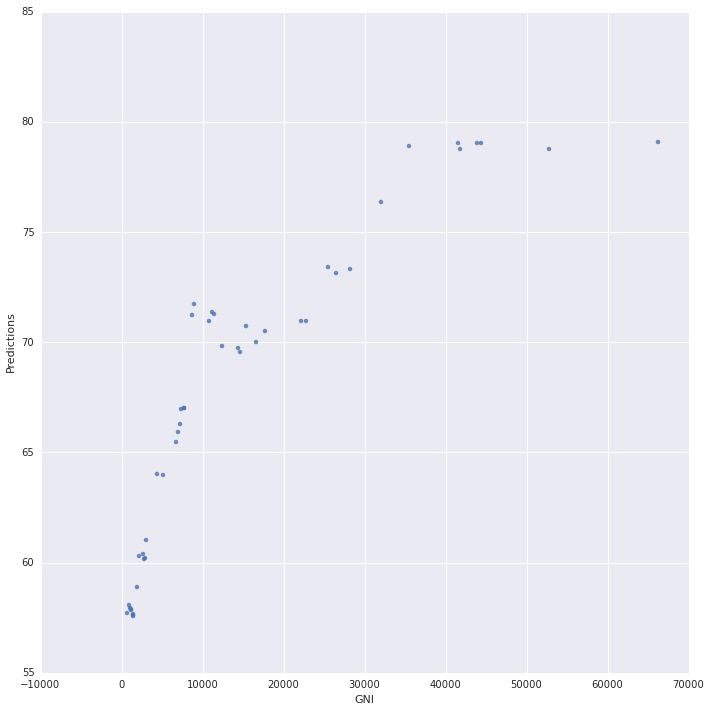

In [14]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=15)

threshold = 0.7
train = df_knn[df_knn['Random'] < threshold].copy()
test = df_knn[df_knn['Random'] >= threshold].copy()
# Fit the model on the training data.
knn.fit(train['GNI'].reshape(len(train), 1), train['Male Expectancy'])
# Make point predictions on the test set using the fit model.
predictions = knn.predict(test['GNI'].reshape(len(test), 1))

test['Predictions'] = predictions
test.head()

#grid = seaborn.lmplot('GNI', 'Male Expectancy', data=test, fit_reg=False, size=10, y_jitter=0.2, palette='Set1')
grid = seaborn.lmplot('GNI', 'Predictions', data=test, fit_reg=False, size=10, y_jitter=0.2, palette='Set1')
